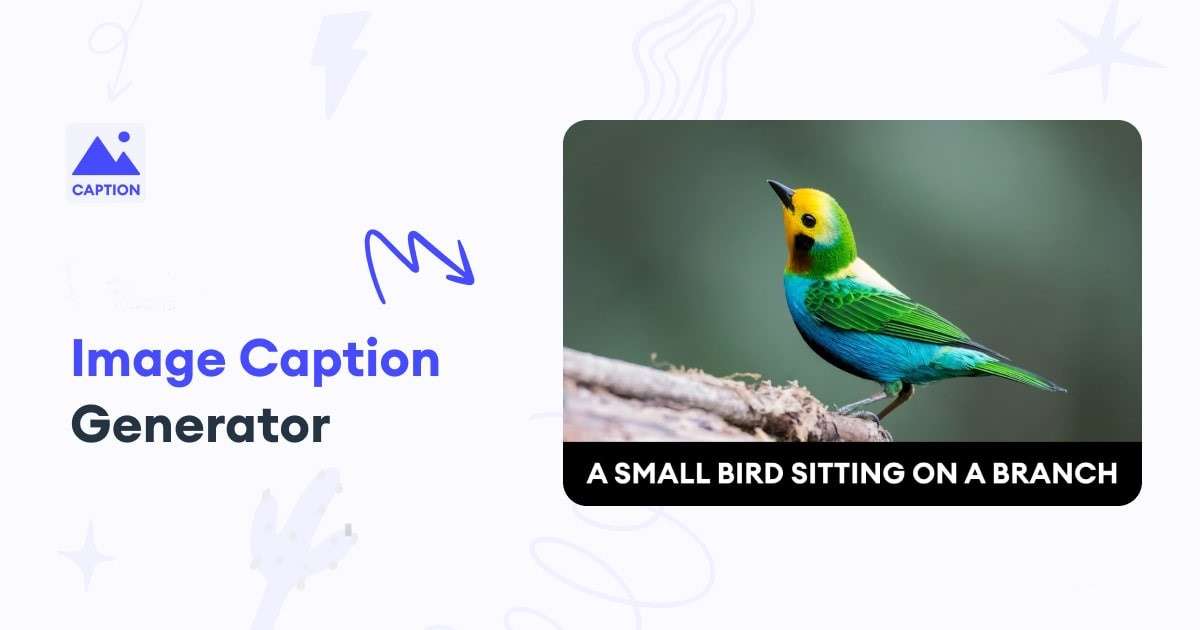


## **Introduction**
This project focuses on developing an image captioning system using Inception V3, a cutting-edge convolutional neural network, and the Flickr 8K dataset. The goal is to automatically generate contextually relevant captions for diverse images.

**Objectives:**
Create a model that combines the visual features extracted by Inception V3 with natural language processing to generate coherent captions for images in the Flickr 8K dataset.

**Technologies:**
Utilizing Inception V3 for feature extraction and TensorFlow with Keras for model implementation and training.

**Dataset:**
Flickr 8K dataset, comprising 8,000 images with multiple human-generated captions for each, providing diversity for effective model training.

**Methodology:**
Inception V3 extracts visual features, and a sequence-to-sequence model with LSTM cells generates captions based on these features.

Expected Outcomes:
Accurate and contextually relevant captions for diverse images, with the model demonstrating generalization to unseen data.

# **Downloading dataset to colab from kaggle**

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

In [ ]:
!cp '/content/flickr8k.zip' '/content/drive/MyDrive'

In [ ]:
!cp '/content/drive/MyDrive/flickr8k.zip' '/content'

In [ ]:
!mkdir flickr8k

In [ ]:
!unzip '/content/flickr8k.zip' -d '/content/flickr8k'

# **Importing necessary packages and libraries**

In [ ]:
import os
import pickle
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

# **Assigning Directories**

In [ ]:
data_dir = '/content/flickr8k'
images_dir = os.path.join(data_dir, 'Images')
caption_file = os.path.join(data_dir, 'captions.txt')

# **Create InceptionV3 model without the final classification layer**


In [ ]:
inception_model = InceptionV3(weights='imagenet')
inception_model = Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

# **Extracting, saving and loading img_features dictionary containing each image feature**

In [ ]:
img_features = {}

for img_name in tqdm(os.listdir(images_dir)):
  img_path = os.path.join(images_dir,img_name)
  img = load_img(img_path, target_size=(299,299))
  img = img_to_array(img)
  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  img = preprocess_input(img)
  feature = inception_model.predict(img, verbose=0)
  img_features[img_name] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
with open('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/img_features.pkl', 'wb') as f:
    pickle.dump(img_features, f)

In [ ]:
with open('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/img_features.pkl', 'rb') as f:
    img_features = pickle.load(f)

# **Loading the captions.txt file**

In [ ]:
with open('/content/flickr8k/captions.txt','r') as caption:
    caption_doc = caption.read()

* **remove the header from the caption**


In [ ]:
lines = caption_doc.split('\n')
caption_doc = lines[1:]

In [ ]:
caption_doc[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

# **Preprocess text data**

In [ ]:
import re

caption_dict = {}

for line in tqdm(caption_doc):
    tokens = line.split(',')

    if len(tokens) < 2:
        continue

    img_name, caption = tokens[0], tokens[1]

    # Preprocess the caption
    caption = caption.lower()
    caption = re.sub(r'[^a-z ]', '', caption)
    caption = re.sub(r'\s+', ' ', caption).strip()
    caption = 'startseq' + ' ' + caption + ' ' + 'endseq'

    if img_name not in caption_dict:
        caption_dict[img_name] = []
    caption_dict[img_name].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(caption_dict)

8091

* **Tokenizing the each caption**

In [ ]:
all_captions = []

for key, caption in caption_dict.items():
  for i in caption:
    all_captions.append(i)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(all_captions)
vocab_size = len((tokenizer.word_index))+1
print(vocab_size)

8589


In [ ]:
# max_length of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
caption_dict['1000268201_693b08cb0e.jpg']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [ ]:
img_features['1000268201_693b08cb0e.jpg'][0]

array([0.12277618, 0.3329308 , 0.7527244 , ..., 0.2194148 , 0.302085  ,
       0.40279683], dtype=float32)

# **Train Test Split**

In [ ]:
img_name = list(caption_dict.keys())
split = int(len(img_name) * 0.90)
train = img_name[:split]
test = img_name[split:]

# **Data generator**

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data, caption_dict, img_features, tokenizer, max_length, vocab_size, batch_size):
    feature_in, caption_inp, caption_out = list(), list(), list()
    n = 0
    while 1:
        for key in data:
            n += 1
            captions = caption_dict[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    feature_in.append(img_features[key][0])
                    caption_inp.append(in_seq)
                    caption_out.append(out_seq)
            if n == batch_size:
                feature_in, caption_inp, caption_out = np.array(feature_in), np.array(caption_inp), np.array(caption_out)
                yield [feature_in, caption_inp], caption_out
                feature_in, caption_inp, caption_out = list(), list(), list()
                n = 0

# **Model creation**

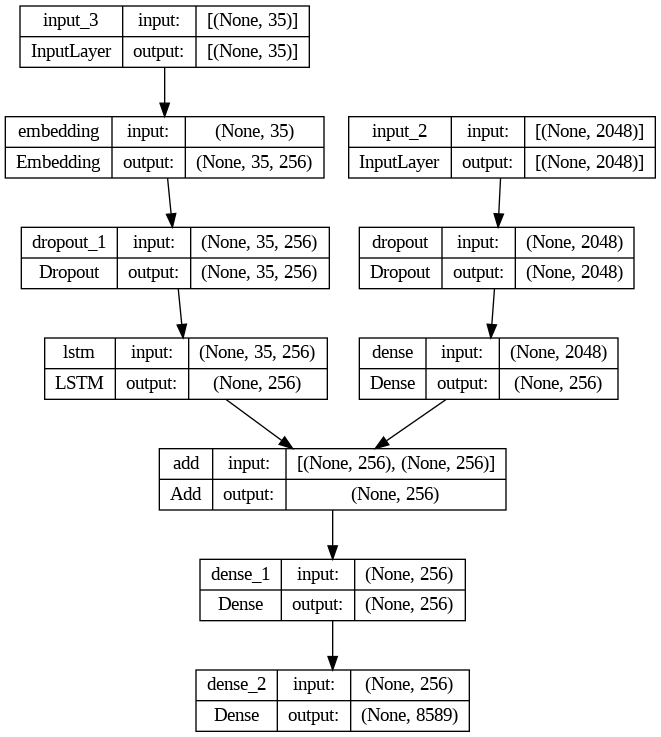

In [ ]:
# ENCODER LAYERS
# image feature layer
input1 = Input(shape=(2048,))
if1 = Dropout(0.4)(input1)
if2 = Dense(256, activation='relu')(if1)

# caption layer
input2 = Input(shape=(max_length,))
cg1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
cg2 = Dropout(0.4)(cg1)
cg3 = LSTM(256)(cg2)

# DECORDER LAYERS
decoder1 = add([if2,cg3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs = [input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2198784   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

# **Training the model, saving and loading it**

In [ ]:
epoch = 50
batch_size = 32
steps = len(train) // batch_size

for i in tqdm(range(epoch)):
  generator = data_generator(train, caption_dict, img_features, tokenizer, max_length, vocab_size, batch_size)
  model.fit(generator, epochs=1, steps_per_epoch = steps, verbose=1)

  0%|          | 0/50 [00:00<?, ?it/s]

227/227 [==============================] - 58s 255ms/step - loss: 1.5327


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/1.5327.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/1.5327.h5')

# **Generate caption for the image**

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    generated_caption = 'startseq'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([generated_caption])[0]
        pad = pad_sequences([sequence], maxlen=max_length)
        word = model.predict([image, pad])
        word_index = np.argmax(word)
        word = tokenizer.index_word.get(word_index, None)

        if word is None:
            break
        else:
            if word != 'startseq' and word != 'endseq':
                generated_caption += ' ' + word

        if word == 'endseq':
            break

    # Remove startseq and endseq from the final caption
    generated_caption = generated_caption.replace('startseq', '').replace('endseq', '').strip()

    return generated_caption

# **Evaluation with test data**

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in test:
    captions = caption_dict[key]
    predicted_cap = predict_caption(model, img_features[key], tokenizer, max_length)
    # adding startseq and endseq to the predicted_cap since we removed it earlier for presentation
    predicted_cap = 'startseq ' + predicted_cap + ' endseq'
    predicted_cap = predicted_cap.split()
    actual_cap = [caption.split() for caption in captions]

    actual.append(actual_cap)
    predicted.append(predicted_cap)

# Calculate BLEU scores
bleu1_score = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2_score = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

In [ ]:
# Print the scores
print(f"BLEU-1: {bleu1_score}")
print(f"BLEU-2: {bleu2_score}")

BLEU-1: 0.5776064679890947
BLEU-2: 0.39069829923158916


# **Predicting caption with a new image**

In [ ]:
extractor_model = InceptionV3(weights='imagenet')
extractor_model = Model(inputs = extractor_model.inputs, outputs = extractor_model.layers[-2].output)

In [ ]:
def enter_image_path(path):
    image_path = path
    image = load_img(image_path, target_size=(299, 299), color_mode='rgb')
    image = img_to_array(image)
    image = preprocess_input(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Extract features using the model
    feature = extractor_model.predict(image, verbose=0)

    # Generate caption
    caption = predict_caption(model, feature, tokenizer, max_length)

    # Display the image
    path = image_path
    image = Image.open(path)
    plt.imshow(image)
    plt.show()

    return caption

1/1 [==============================] - 0s 28ms/step


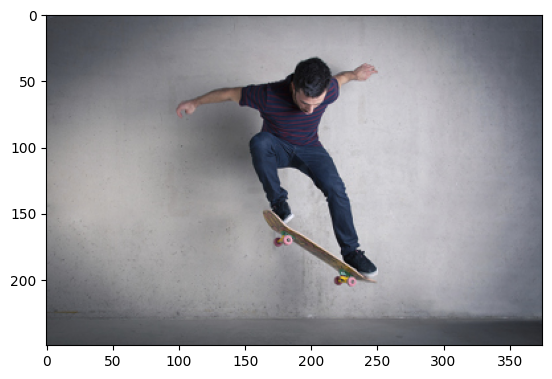

'a boy in a red shirt skateboards on the street'

In [ ]:
enter_image_path('/content/ImageCaptioningSample5-14b26724.png')

1/1 [==============================] - 0s 28ms/step


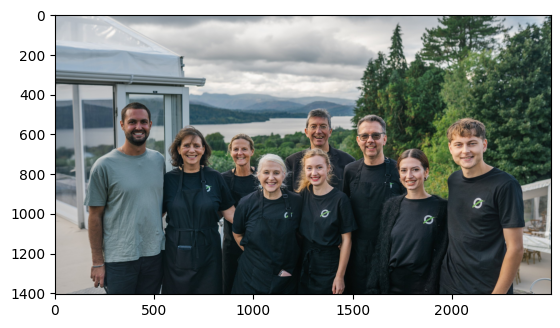

'a group of adults stand in front of a large fountain'

In [ ]:
enter_image_path('/content/Chefs4SW-2-64.jpeg')

1/1 [==============================] - 0s 26ms/step


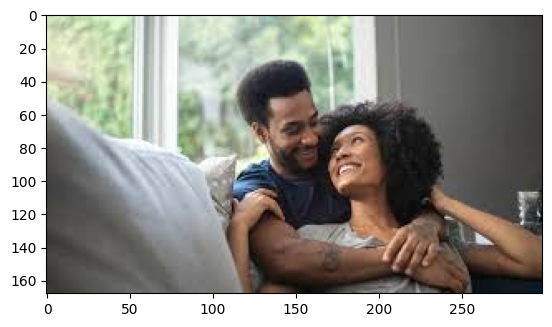

'a man and woman kiss'

In [ ]:
enter_image_path('/content/images (4).jpeg')

1/1 [==============================] - 0s 25ms/step


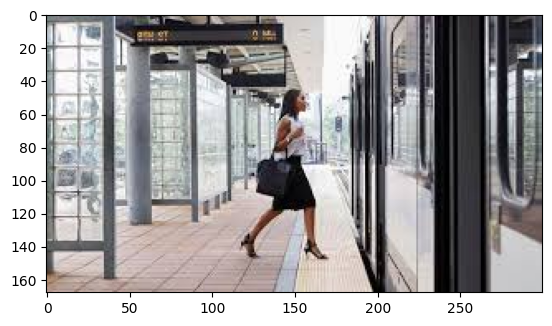

'a woman in a blue jacket is walking past a train window where a woman walks along the sidewalk'

In [ ]:
enter_image_path('/content/images (5).jpeg')

1/1 [==============================] - 0s 35ms/step


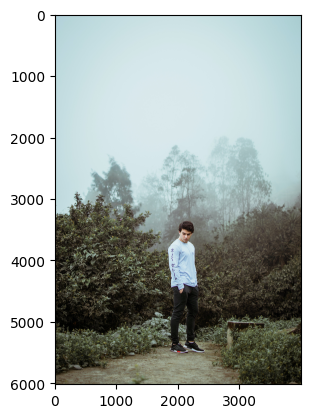

'a woman in a green shirt and a man in a white shirt are walking on a sunny day'

In [ ]:
enter_image_path('/content/lino-montes-QZge5rhkgSs-unsplash.jpg')

1/1 [==============================] - 0s 27ms/step


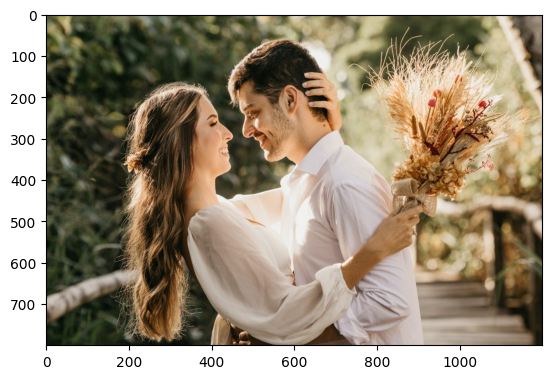

'a man in a white shirt and a man in a white shirt are playing in a sprinkler'

In [ ]:
enter_image_path('/content/Captions+for+Girlfriend.jpg')

1/1 [==============================] - 0s 27ms/step


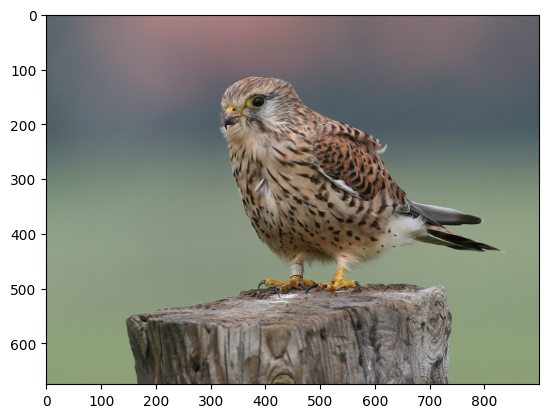

'a large bird is flying over the grass'

In [ ]:
enter_image_path('/content/bird-1383764.jpg')

1/1 [==============================] - 0s 27ms/step


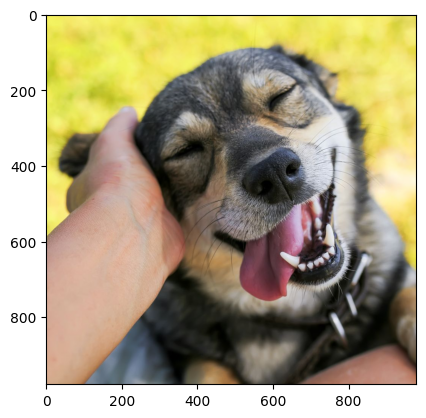

'a dog is running through the snow'

In [ ]:
enter_image_path('/content/funny-dog-captions-1563456605.jpg')

1/1 [==============================] - 0s 26ms/step


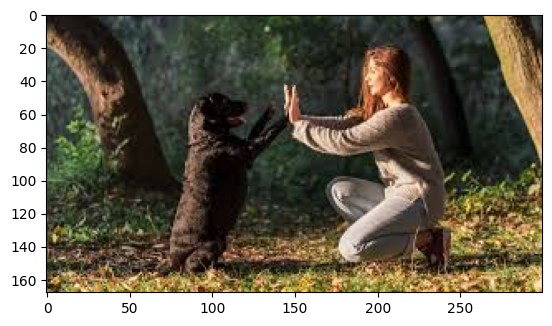

'a black dog jumping into a lake'

In [ ]:
enter_image_path('/content/images (1).jpeg')

1/1 [==============================] - 0s 40ms/step


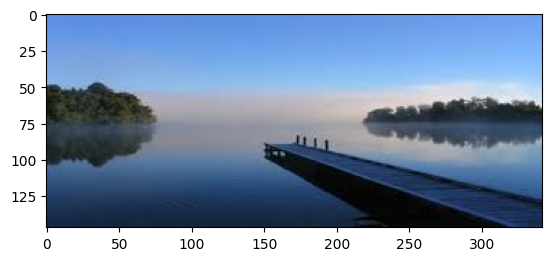

'a man is wading in a lake with a statue in the background'

In [ ]:
enter_image_path('/content/images (2).jpeg')

1/1 [==============================] - 0s 40ms/step


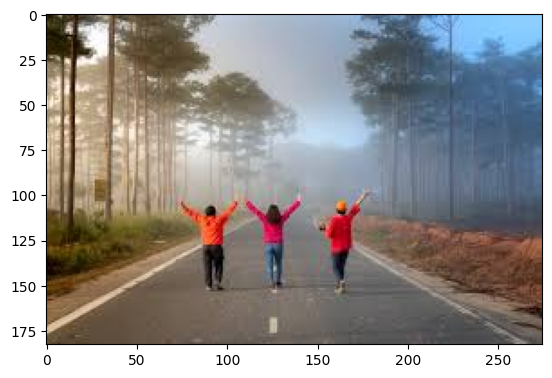

'a man in a green shirt is walking a small wave on a busy brightlycolored scooter'

In [ ]:
enter_image_path('/content/images (3).jpeg')

1/1 [==============================] - 0s 27ms/step


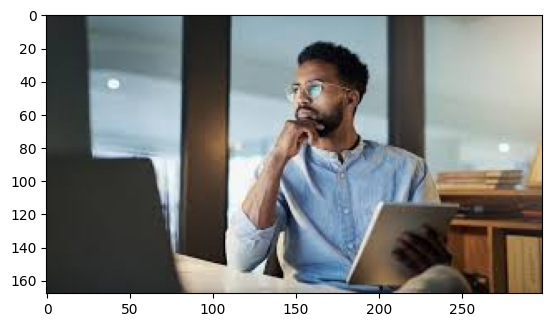

'a man in a black hat and glasses is speaking to a woman in a black shirt'

In [ ]:
enter_image_path('/content/images (6).jpeg')

1/1 [==============================] - 0s 35ms/step


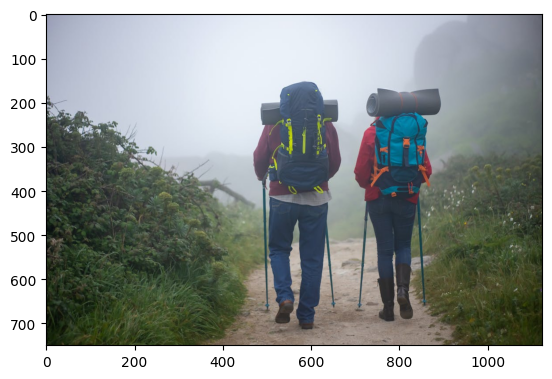

'a woman in a red jacket and a backpack walks beside a green tent with a white backpack'

In [ ]:
enter_image_path('/content/pexels-photo-7787422.jpeg')